# Import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import xgboost as xgb 
from xgboost import plot_importance , XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from sklearn.metrics import *

In [2]:
from tqdm import notebook

import shap

# Read Data

In [3]:
train_original = pd.read_csv('./open data/train.csv')
test_original = pd.read_csv('./open data/test_x.csv')
train = train_original.copy()
test = test_original.copy()

# Data

In [4]:
# fill NA
def fill_married(data):
    pdata = data.copy()
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='10s'),'married' ] = 1
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='20s'),'married' ] = 1
    pdata.loc[pdata.married==0,'married'] = 2
    
    return pdata

def fill_education(data):
    pdata = data.copy()
    pdata.loc[(pdata.education==0)&(pdata.age_group=='10s'),'education'] = 2
    pdata.loc[pdata.education==0,'education'] = 3

    return pdata

def fill_engnat(data):
    pdata = data.copy()
    pdata.loc[pdata.engnat==0,'engnat'] = 1
    
    return pdata

def fill_hand(data):
    pdata = data.copy()
    pdata.loc[pdata.hand==0,'hand'] = 1
    
    return pdata
# feature engineering
def Mach_score(data):
    pdata = data.copy()
    Answers = []
    for i in range(20):
        Answers.append('Q'+chr(97+i)+'A')
    reverse_col = ['QeA','QfA','QkA','QqA','QrA','QaA','QdA','QgA','QiA','QnA']
    for col in reverse_col:
        pdata[col] = -pdata[col]
    pdata['Mach_score'] = pdata[Answers].sum(axis=1)
    
    return pdata

def w_score(data):
    pdata = data.copy()
    wr = []
    wf = []
    for i in range(1,14):
        wr.append(f'wr_{i:02d}')
    for i in range(1,4):
        wf.append(f'wf_{i:02d}')
    
    pdata['wr'] = pdata[wr].sum(axis=1)
    pdata['wf'] = pdata[wf].sum(axis=1)
    
    return pdata

def TIPI(data):
    pdata = data.copy()
    pdata['tp_score_1'] = pdata['tp01'] - pdata['tp06']
    pdata['tp_score_2'] = pdata['tp07'] - pdata['tp02']
    pdata['tp_score_3'] = pdata['tp03'] - pdata['tp08']
    pdata['tp_score_4'] = pdata['tp09'] - pdata['tp04']
    pdata['tp_score_5'] = pdata['tp05'] - pdata['tp10']
    
    return pdata

# drop outlier
def drop_outlier(data, datatype):
    
    assert datatype == 'train' or datatype=='test', 'Wrong data type given'
    
    pdata = data.copy()
    if datatype=='train':
        
        out_arr = []
        out_arr.append( np.where(data['familysize']>=16)[0] )
        out_arr.append( np.where(data.wr<=3)[0] )
        out_arr.append( np.where(data.wf>=2)[0] )

        out = []
        for outarr in out_arr:
            out = np.union1d(out, outarr)

        pdata = data.drop(out)
    
    return pdata
# feature banding
def age_band(data):
    pdata = data.copy()
    pdata['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,5,5],inplace=True)
    
    return pdata

def E_band(data, num_band):
    pdata = data.copy()
    for i in range(20):
        col = 'Q'+chr(i+97)+'E'
        pdata[col] = pd.qcut(pdata[col],num_band)
        unique = pdata[col].unique()
        pdata[col].replace(unique,range(num_band),inplace=True)
        
    return pdata

def family_band(data):
    pdata = data.copy()
    pdata.loc[pdata.familysize >= 6,'familysize'] = 6
    
    return pdata
# categorical value to numerical value
def cat_gender(data):
    feature = 'gender'
    pdata = data.copy()
    pdata[feature].replace(['Male','Female'],[0,1],inplace=True)
    
    return pdata

def cat_race(data):
    feature = 'race'
    pdata = data.copy()
    unique = ['White', 'Asian', 'Other', 'Black', 'Native American', 'Arab', 'Indigenous Australian']
    pdata[feature].replace(unique,[0,1,2,3,4,5,6],inplace=True)
    
    return pdata

def cat_religion(data):
    feature = 'religion'
    pdata = data.copy()
    unique = ['Other', 'Hindu', 'Agnostic', 'Atheist', 'Christian_Other',
       'Christian_Catholic', 'Muslim', 'Buddhist', 'Christian_Protestant',
       'Jewish', 'Christian_Mormon', 'Sikh']
    pdata[feature].replace(unique,[11,10,0,1,2,3,4,5,6,7,8,9],inplace=True)
    
    return pdata

def cat_num(data):
    pdata = data.copy()
    pdata = cat_gender(pdata)
    pdata = cat_race(pdata)
    pdata = cat_religion(pdata)
    
    return pdata
# drop feature
def drop_feature(data, feature_arr):
    feature_arr += ['index'] 
    
    """for i in range(20):
        feature_arr.append('Q'+chr(i+97)+'A')
    for i in range(20):
        feature_arr.append('Q'+chr(i+97)+'E')
    for i in range(1,14):
        feature_arr.append(f'wr_{i:02d}')
    for i in range(1,4):
        feature_arr.append(f'wf_{i:02d}')
    for i in range(1,11):
        feature_arr.append(f'tp{i:02d}')"""
    

    pdata = data.drop(feature_arr,axis=1)
    
    return pdata


In [5]:
def preprocess(data, datatype, feature_arr):
    
    pdata = data.copy()
    # fill NA
    pdata = fill_married(pdata)
    pdata = fill_education(pdata)
    pdata = fill_engnat(pdata)
    pdata = fill_hand(pdata)
    # feature engineering
    pdata = Mach_score(pdata)
    pdata = w_score(pdata)
    pdata = TIPI(pdata)
    # drop outlier
    pdata = drop_outlier(pdata,datatype)
    # feature banding
    pdata = age_band(pdata)
    pdata = family_band(pdata)
    pdata = E_band(pdata,10)
    # categorical value to numerical value
    pdata = cat_num(pdata)
    # drop feature
    pdata = drop_feature(pdata, feature_arr)
    # unify type of data
    pdata = pdata.astype(np.int)
    
    return pdata

# XGBoost

In [6]:
val = train.iloc[38703:,:] # 15%
train = train.iloc[:38703,:]

In [7]:
opt = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.010,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

In [9]:
opt_arr_1 = ['QbA','QcA','QjA','QhA','QmA','QtA','QlA','QkA','QoA',
 'QsA','QrA', 'QeA',  'QnA','QgA', 'QdA'] + \
['QaE','QbE','QcE','QeE','QgE','QmE','QfE','QiE','QoE',
 'QlE','QrE','QpE','QnE','QtE','QsE','QkE'] + \
['tp01','tp04','tp05','tp09','tp10','tp02', 'tp08'] +\
['wf_01', 'wf_03'] + \
['wr_06','wr_09', 'wr_11','wr_07', 'wr_12','wr_13'] +\
['tp_score_4','hand']

opt_arr_2 = ['QjA','QaE', 'QbA', 'QeE', 'QfE', 'QhA', 'QiE', 'tp09', 'tp_score_4',
      'QbE', 'QtA', 'tp01', 'tp_score_2',
       'QmA', 'QmE', 'tp04',
       'QgE', 'QkA', 'QoE', 'QsA',
       'QlE', 'QoE', 'QrE', 'wf_03',
       'QoA', 'QlA', 'QsE', 'tp10',
       'QpE', 'tp08', 'wf_01',
       'QkE', 'QrA', 'wr_05', 'wr_09', 'wr_10', 'wr_11',
       'QgA', 'QtE', 'hand', 'tp06', 'QeA', 'wr_06', 'wr_12',
       'wr_03', 'wr_07', 'QdA', 'QdE', 'QnE', 'wr_13'
      ]

# SHAP

In [10]:
def shap_summary(param, bad):
    train_x = preprocess(train,'train', bad)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    val_x = preprocess(val,'test', bad)
    val_y = val_x['voted']
    val_x = val_x.drop(['voted'],axis=1)
    
    model = XGBClassifier(**param)
    model.fit(train_x,train_y,verbose=False)
    
    explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(val_x)
    
    return shap.summary_plot(shap_values, val_x, max_display=val_x.shape[1])

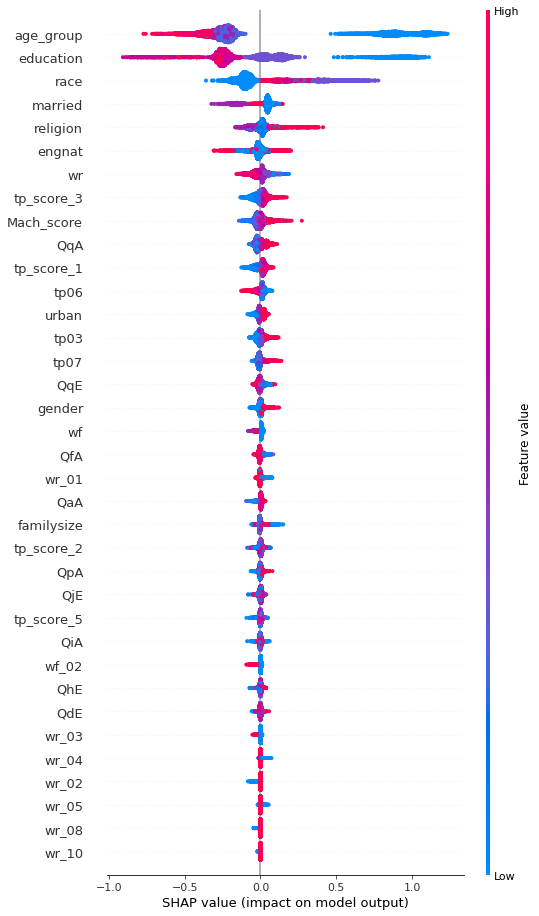

In [11]:
shap_summary(opt, opt_arr_1)

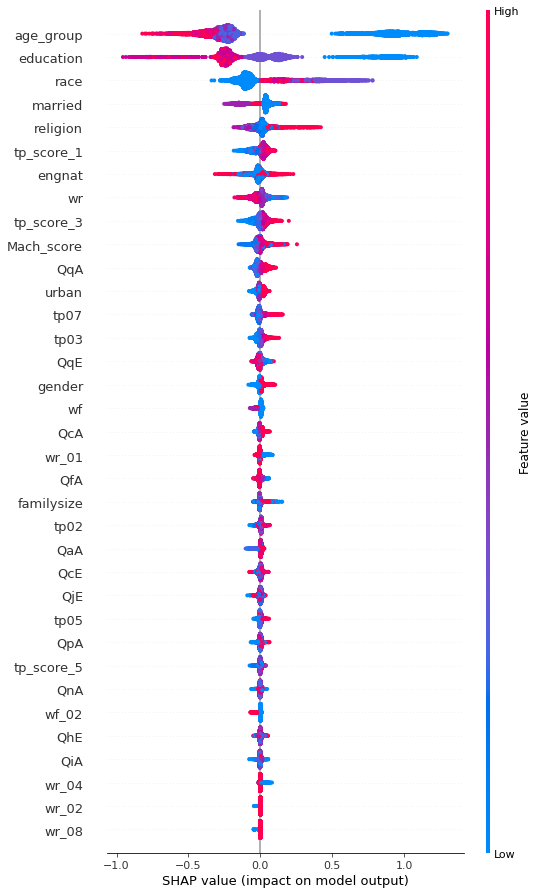

In [12]:
shap_summary(opt, opt_arr_2)